In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import scipy
import string
import time
from __future__ import division
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import *
import nltk
from spacy.lemmatizer import Lemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from netCDF4 import Dataset
import multiprocessing
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from gensim.models.phrases import Phrases, Phraser

C:\Anaconda3\envs\chatbot\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_json("reviews.json")
nlp = spacy.load('en')
reviews = df.loc[:, "Review"]
scores = df.loc[:, "Score"]
helpful = df.loc[:, "How helpful"]

In [3]:
# extract rating score of each product and astype int
for index, score in enumerate(scores):
    doc = nlp(score)
    scores.at[index] = doc.ents[0].text[0]
scores = scores.astype('int')
# save rating score as int and; 0 if none data collected
for index, h in enumerate(helpful): 
    doc = nlp(h)
    if not doc.ents:
        helpful.at[index] = 0
    else:
        score = doc.ents[1].text
        if score == 'One':
            helpful.at[index] = 1
        else:
            helpful.at[index] = score
helpful = helpful.astype('int')

In [4]:
# Combine helpful & reviews as features and scores as labels
X = reviews
y = scores
data = pd.DataFrame({'helpful': helpful, 'reviews': reviews, 'scores': scores})

In [203]:
X.describe()

count               851
unique              821
top       great product
freq                  8
Name: Review, dtype: object

In [6]:
data.corr()

,helpful,scores
helpful,1.00000,-0.02641
scores,-0.02641,1.00000


In [7]:
%matplotlib inline

(array([850.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  21.6,  43.2,  64.8,  86.4, 108. , 129.6, 151.2, 172.8,
        194.4, 216. ]),
 <a list of 10 Patch objects>)

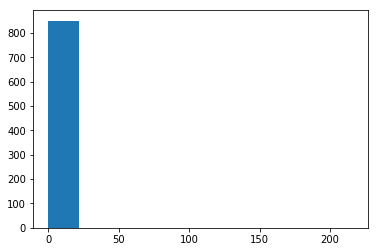

In [8]:
plt.hist(data['helpful'], bins=10)

In [9]:
pd.value_counts(y)

5    548
4    117
1     81
3     53
2     52
Name: Score, dtype: int64

In [10]:
# calculate line counts and word counts
line_count = data['reviews'].shape[0]
count_words = 0
for review in reviews:
    count_words = count_words + len(review)
print("Num of lines: ", line_count)
print("Num of words: ", count_words)

('Num of lines: ', 851L)
('Num of words: ', 132818)


In [11]:
%matplotlib inline
review_length = data['reviews'].apply(lambda r: len(r))
review_length.describe()

count     851.000000
mean      156.072855
std       196.925216
min         4.000000
25%        39.000000
50%        93.000000
75%       202.500000
max      2420.000000
Name: reviews, dtype: float64

In [12]:
review_length = X.apply(lambda r: len(r))
review_length.describe()

count     851.000000
mean      156.072855
std       196.925216
min         4.000000
25%        39.000000
50%        93.000000
75%       202.500000
max      2420.000000
Name: Review, dtype: float64

In [13]:
data.describe()[['helpful', 'scores']]

,helpful,scores
count,851.00000,851.000000
mean,0.59812,4.173913
std,7.46510,1.333840
min,0.00000,1.000000
25%,0.00000,4.000000
50%,0.00000,5.000000
75%,0.00000,5.000000
max,216.00000,5.000000


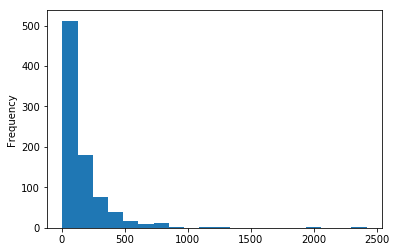

In [14]:
%matplotlib inline
review_length.plot(kind='hist', bins=20)

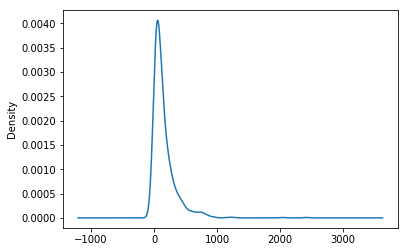

In [15]:
review_length.plot(kind='kde')

In [166]:
# Now we are going to clean up the reviews
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence
X = X.apply(cleanup)

In [158]:
class PartOfSpeechFilter(BaseEstimator, TransformerMixin):
    def __init__(self, pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'), stop_words=None):
        self.pos_to_keep = pos_to_keep
        self.stop_words = stop_words
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        preprocessed_sentences = []
        
        for doc in nlp.pipe(X, n_threads=8):
            if self.stop_words is not None:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep and t.lemma_ not in self.stop_words])
            else:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep])
            preprocessed_sentences.append(keep_tokens_string)
    
        return preprocessed_sentences

In [170]:
# implement tfidfvectorizer
tfidf = TfidfVectorizer(analyzer = "word", max_features = 1000, 
                        stop_words="english", ngram_range=(1,2))
features = tfidf.fit_transform(X).toarray()

In [192]:
# select top 5 features
tfidf_tags = []
top_n = -5
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(features)
for i, e in enumerate(tfidf_sorting):
    tmp_tags = []
    indexes = e[top_n:]
    for idx in indexes:
        cur_tag = feature_array[idx]
        if features[i][idx] > 0.1 and len(cur_tag)>3 and '_' not in cur_tag:
            tmp_tags.append(cur_tag.replace(' ', '-'))
    tfidf_tags.append(" ".join(tmp_tags))

In [193]:
new_features = tfidf.fit_transform(tfidf_tags).toarray()

In [76]:
from gensim.models.phrases import Phrases, Phraser

C:\Anaconda3\envs\chatbot\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [184]:
sum_down_columns = features.sum(axis=0)
# np.array(sum_down_columns).shape[0]
counts_per_word = list(zip(tfidf.get_feature_names(), sum_down_columns))
sorted(counts_per_word, key=lambda t: t[1], reverse=True)[:50]

[(u'great', 49.53513403012258),
 (u'bright', 41.389804597350334),
 (u'light', 39.49184433625329),
 (u'good', 39.16227558388151),
 (u'flashlights', 31.082812523055743),
 (u'flashlight', 27.804514599237184),
 (u'small', 24.291223062279773),
 (u'price', 23.476812287980376),
 (u'little', 22.32611534913841),
 (u'work', 21.999509033519818),
 (u'battery', 20.725166582808754),
 (u'nice', 18.762169365813957),
 (u'like', 18.095750529517204),
 (u'lights', 17.272996592704278),
 (u'works', 16.904765016465994),
 (u'product', 16.703475050825727),
 (u'use', 16.589424227342995),
 (u'size', 15.71094083171448),
 (u'love', 14.745597603193481),
 (u'just', 14.585896756742724),
 (u'batteries', 14.12140959837454),
 (u'perfect', 13.563678319861998),
 (u'quality', 13.25496674613295),
 (u'really', 12.579410512262069),
 (u'aa', 12.44398124924892),
 (u'awesome', 12.322576507559491),
 (u'compact', 12.228819827530877),
 (u'excellent', 11.767190728630458),
 (u'pocket', 11.018122060720959),
 (u'time', 10.8369374848719

In [195]:
# split train test datasets on original data
X_train, X_test, y_train, y_test = train_test_split(new_features, y, test_size=0.33, random_state=42)
# Oversample the data and split train test
ros = RandomOverSampler()
X_oversample, y_oversample = ros.fit_sample(new_features, y)
X_oversample_train, X_oversample_test, y_oversample_train, y_oversample_test = train_test_split(X_oversample, y_oversample, test_size=0.33, random_state=42)

# Build LR model

In [196]:
# LR parameters and randomized the best param
param_grid = {'C': np.linspace(1e-5, 1e5, 10), 'penalty': ['l1', 'l2']}
lr = LogisticRegression()
model_lr = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy', n_iter=20)

In [197]:
# fitting model with oversampled data
model_lr.fit(X_oversample_train, y_oversample_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.11111e+04, 2.22222e+04, 3.33333e+04, 4.44444e+04,
       5.55556e+04, 6.66667e+04, 7.77778e+04, 8.88889e+04, 1.00000e+05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='accuracy', verbose=0)

In [198]:
# print out the accuracy on testing data
y_pred = model_lr.predict(X_oversample_test)
print(metrics.accuracy_score(y_pred,y_oversample_test))

0.8674033149171271


# Build svm model

In [148]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics

In [208]:
print("Fitting Oversampled data")
svc = svm.SVC()

Fitting Oversampled data


In [209]:
tuned_parameters = {
    'C': [1,10,100,500,1000], 'kernel':['linear','rbf'],
    'C': [1,10,100,500,1000], 'gamma':[1,0.1,0.01,0.001,0.0001], 'kernel':['rbf'],
    'degree':[2,3,4,5,6], 'C':[1,10,100,500,1000], 'kernel':['poly']
}
model_svm = RandomizedSearchCV(svc, tuned_parameters, cv=10, scoring='accuracy', n_iter=20)

In [210]:
model_svm.fit(X_oversample_train, y_oversample_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'kernel': ['poly'], 'C': [1, 10, 100, 500, 1000], 'degree': [2, 3, 4, 5, 6], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='accuracy', verbose=0)

In [211]:
model_svm.best_params_

{'C': 1000, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}

In [212]:
y_pred = model_svm.predict(X_oversample_test)
print("Fitting svm with oversampled data", metrics.accuracy_score(y_pred,y_oversample_test))

('Fitting svm with oversampled data', 0.907182320441989)


# Implement random forest

In [199]:
from sklearn.ensemble import RandomForestClassifier
rfc =  RandomForestClassifier()
param_dist = {"n_estimators": [10,20,30,50,100],
              'max_depth':[2,4,6,8,10,None],
              'min_samples_leaf':[1,5,10,20,40]
             }
model_rfc = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='accuracy', n_iter=20)
model_rfc.fit(X_oversample_train, y_oversample_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': [10, 20, 30, 50, 100], 'max_depth': [2, 4, 6, 8, 10, None], 'min_samples_leaf': [1, 5, 10, 20, 40]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='accuracy', verbose=0)

In [200]:
y_pred = model_rfc.predict(X_oversample_test)
print("Fitting svm with oversampled data", metrics.accuracy_score(y_pred,y_oversample_test))

('Fitting svm with oversampled data', 0.881767955801105)


# Conclusion:
By training tree models in respect of multiple parameters, SVM has the highest accuracy aove 90 over the other two.
With parameter: {'C': 1000, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'} when max_features = 1000
According to experiments, the large value of max_feature is, the higher its accuracy is but much slower the process would be.
Accuracy : 0.9458563535911603 when max_features = 5000
So we need to achieve our best result out of max feature after speed-accuracy tradeoff consideration.